# Unsupervised Learning on LendingClub data
Can Kmeans predict a good vs a bad loan?

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, SpectralClustering
from sklearn.decomposition import TruncatedSVD  # a form of PCA for NLP
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize,scale

from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [23]:
#import warnings
#warnings.filterwarnings('ignore')

In [24]:
df = pd.read_csv('lending_club_le.csv')

In [25]:
df.head()

,Unnamed: 0,loan_amnt,installment,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,title,addr_state,revol_util,initial_list_status,application_type
0,5,3000.0,93.10,52000.0,0.58,0.0,7.0,0.0,141.0,30.0,...,9,3,1,0,5,7,46,5,1,0
1,14,5000.0,166.03,55000.0,14.18,0.0,14.0,1.0,11449.0,24.0,...,1,2,0,0,8,10,10,334,1,0
2,23,20300.0,509.66,55000.0,26.63,0.0,10.0,0.0,17506.0,26.0,...,10,3,2,0,1,2,33,744,1,0
3,28,7000.0,232.44,40000.0,20.25,0.0,13.0,0.0,5004.0,29.0,...,10,1,2,0,3,6,42,355,1,0
4,34,10000.0,326.92,52320.0,12.87,1.0,6.0,1.0,1692.0,26.0,...,10,3,1,0,2,3,46,380,1,0


In [26]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [27]:
df.shape

(73318, 69)

In [28]:
df.good_loan_status.value_counts()

1    56725
0    16593
Name: good_loan_status, dtype: int64

In [29]:
56725/(16593+56725)

0.7736844976676942

---

In [30]:
y=df['good_loan_status']
X=scale(df.drop(['good_loan_status'],axis=1))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, 
                                                    random_state=42)

In [32]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((58654, 68), (58654,), (14664, 68), (14664,))

In [33]:
# function to determine K
def kClusters(X):
    plt.rcParams['figure.figsize'] = [9, 5]

    squaredSums = []
    K = range(1, 45)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel = kmeanModel.fit(X)
        squaredSums.append(kmeanModel.inertia_)

    # Plot the elbow
    plt.plot(K, squaredSums, 'bx-')
    plt.xlabel('k')
    plt.ylabel('squaredSums')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [34]:
# Find the clusters and plot them

sns.set(style="darkgrid")


def clusterModels(X, y, k):
    fig, ax = plt.subplots(111, figsize=(9,9))
    plt.rcParams.update({'font.size': 15})
    models = []
    names = []
    plt_num = []

    # Normalize the data.
    svd = TruncatedSVD(47)
    lsa = make_pipeline(svd, Normalizer(copy=False))

    # Run SVD on the training data, then project the training data.
    X_lsa = lsa.fit_transform(X)

    models.append((0, 'KMeans', KMeans(n_clusters=k, init='k-means++')))


    for plt_num, name, model in models:
        names.append(name)
        model.fit(X_lsa)
        labels = model.labels_

        ax[plt_num].set_title(name)
        ax[plt_num].scatter(X_lsa[:, 0], X_lsa[:, 1], c=labels)
        print(name)
        print(pd.crosstab(y, labels), '\n\n')

# Kmeans analysis

How accurately is Kmeans about to cluster good loans?

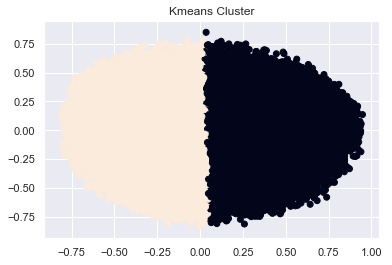

In [41]:
X_norm = normalize(X_train)
X_pca = PCA(2).fit_transform(X_norm)
y_pred = KMeans(n_clusters=2,random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.title('Kmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

In [37]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

Comparing k-means clusters against the data:
good_loan_status     0      1
row_0                        
0                 5638  20280
1                 7669  25067


_PCA is used to reduce the data to 2 components because we are looking to see if Kmeans can predict a good loan_

_Looks like this model isn't doing very well. We're __correctly classifying 30705 (5638+25067)__ cases, but __mis-classifying 27949 (20280+7669)__ of the cases!_


_Let's look at MiniBatch to see if that would be better_

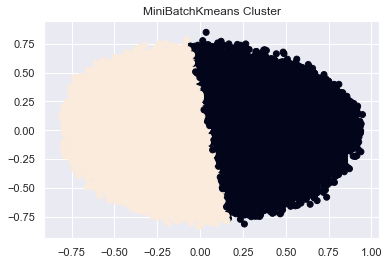

Comparing k-means and mini batch k-means solutions:
good_loan_status     0      1
row_0                        
0                 5403  19872
1                 7904  25475


In [44]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=1000)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)
# Plot the solution.
plt.title('MiniBatchKmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict_mini)
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_train))

MiniBatch Kmeans is able to __classify 30878__ and __mis-classify 27776__ which is about the same as Kmeans.

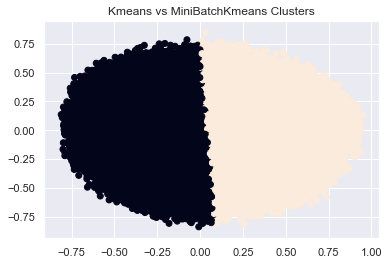

Comparing k-means and mini batch k-means solutions:
col_0      0      1
row_0              
0        391  32576
1      25527    160


In [43]:
plt.title('Kmeans vs MiniBatchKmeans Clusters')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict_mini)
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

# clusters of good loans

In [53]:
kmeans= KMeans(n_clusters=2,random_state=42).fit_predict(X_pca)

In [54]:
kmeans.cluster_centers_

AttributeError: 'numpy.ndarray' object has no attribute 'cluster_centers_'

In [ ]:
def converter(cluster):
    if cluster== 1:
        return 1
    else:
        return 0

In [ ]:
X_train['Cluster'] = X_train['good_loan_status'].apply(converter)

In [ ]:
X_train.Cluster.value_counts()

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(X_train['Cluster'],kmeans.labels_))
print(classification_report(X_train['Cluster'],kmeans.labels_))

_When using 2 cluster, Kmeans 

In [ ]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(X_train['Cluster'],kmeans.labels_)

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth
#from sklearn.datasets.samples_generator import make_blobs
#import matplotlib.pyplot as plt
#from itertools import cycle
#from PIL import Image

_I will take the top 5 features from the supervised learning to see if it can cluster good loans based on the attributes_

In [ ]:
df1 = pd.read_csv('lending_club_le.csv')
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1.shape

In [ ]:
df1.columns

In [ ]:
top5Features=df1[df1.isin(['dti',
                               'max_bal_bc',
                               'months_since_last_credit_pull_d',
                              'mo_sin_old_rev_tl_op',
                               'sub_grade'])]
top5Features=top5Features.drop(['good_loan_status'],axis=1)

In [ ]:
top5Features.head()

In [ ]:
others=df1[~df1.index.isin(['dti',
                               'max_bal_bc',
                               'months_since_last_credit_pull_d',
                              'mo_sin_old_rev_tl_op',
                               'sub_grade'])]

In [ ]:
others.head()

In [ ]:
others.shape

In [ ]:
bandwidth2 = estimate_bandwidth(others.drop('good_loan_status',axis=1),
                                quantile =0.2,n_samples=70)
# introduce the radius, also create bins to store the clusters.
ms=MeanShift(bandwidth2, bin_seeding=True)

In [ ]:
ms.fit(others.drop('good_loan_status',axis=1))
msLabels=ms.labels_

In [ ]:
msLabels

In [ ]:
df1.head()

In [ ]:
others.columns

In [ ]:
dict={}
for var in zip(others,msLabels):
    dict[var[0]]=var[1]
   # if var[1]!=138:
        #print(var)

In [ ]:
dict

In [ ]:
clusters=pd.DataFrame(list(dict.items()), columns=['Features', 'Cluster_MeanShift'])

In [ ]:
clusters.tail(20)

In [ ]:
clusters.Cluster_MeanShift.value_counts()

In [ ]:
predict=ms.predict(top5Features)

In [ ]:
pred

#### the elbow method couldn't find the best k. 

In [ ]:
# find k
kClusters(X)

In [ ]:
clusterModels(X_train, y_train, 7)

In [ ]:
clusterModels(X_test, y_test, 7)